In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 2: Download and load the dataset
!wget https://d3ilbtxij3aepc.cloudfront.net/projects/AI-Capstone-Projects/PRAICP-1003-AirTempTS.zip
!unzip PRAICP-1003-AirTempTS.zip

--2025-05-18 08:21:54--  https://d3ilbtxij3aepc.cloudfront.net/projects/AI-Capstone-Projects/PRAICP-1003-AirTempTS.zip
Resolving d3ilbtxij3aepc.cloudfront.net (d3ilbtxij3aepc.cloudfront.net)... 18.238.248.55, 18.238.248.129, 18.238.248.84, ...
Connecting to d3ilbtxij3aepc.cloudfront.net (d3ilbtxij3aepc.cloudfront.net)|18.238.248.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2815 (2.7K) [application/x-zip-compressed]
Saving to: ‘PRAICP-1003-AirTempTS.zip’

PRAICP-1003-AirTemp 100%[===================>]   2.75K  --.-KB/s    in 0s      

2025-05-18 08:21:54 (705 MB/s) - ‘PRAICP-1003-AirTempTS.zip’ saved [2815/2815]

Archive:  PRAICP-1003-AirTempTS.zip
  inflating: Data/Copy of metadata-surface-air-temperature-monthly-mean.txt  
  inflating: Data/surface-air-temperature-monthly-mean.csv  


In [4]:
# Read the dataset
df = pd.read_csv('Data/surface-air-temperature-monthly-mean.csv')
print("Dataset loaded successfully!")
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset loaded successfully!

First 5 rows of the dataset:
     month  mean_temp
0  1982-01       25.9
1  1982-02       27.1
2  1982-03       27.2
3  1982-04       27.0
4  1982-05       28.0


In [5]:
# Step 3: Data Exploration and Preprocessing
print("\nDataset information:")
print(df.info())

print("\nStatistical summary of the dataset:")
print(df.describe())



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   month      462 non-null    object 
 1   mean_temp  462 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.3+ KB
None

Statistical summary of the dataset:
        mean_temp
count  462.000000
mean    27.665152
std      0.808186
min     25.400000
25%     27.100000
50%     27.700000
75%     28.300000
max     29.500000


In [6]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
month        0
mean_temp    0
dtype: int64


In [9]:
# Convert 'Month' to datetime format if not already
if not pd.api.types.is_datetime64_any_dtype(df['month']):
    df['month'] = pd.to_datetime(df['month'])
    print("\nConverted 'Month' column to datetime format.")



Converted 'Month' column to datetime format.


In [11]:
# Set 'Month' as the index for time series analysis
df.set_index('month', inplace=True)
print("\nDataset with 'Month' as index:")
print(df.head())



Dataset with 'Month' as index:
            mean_temp
month                
1982-01-01       25.9
1982-02-01       27.1
1982-03-01       27.2
1982-04-01       27.0
1982-05-01       28.0


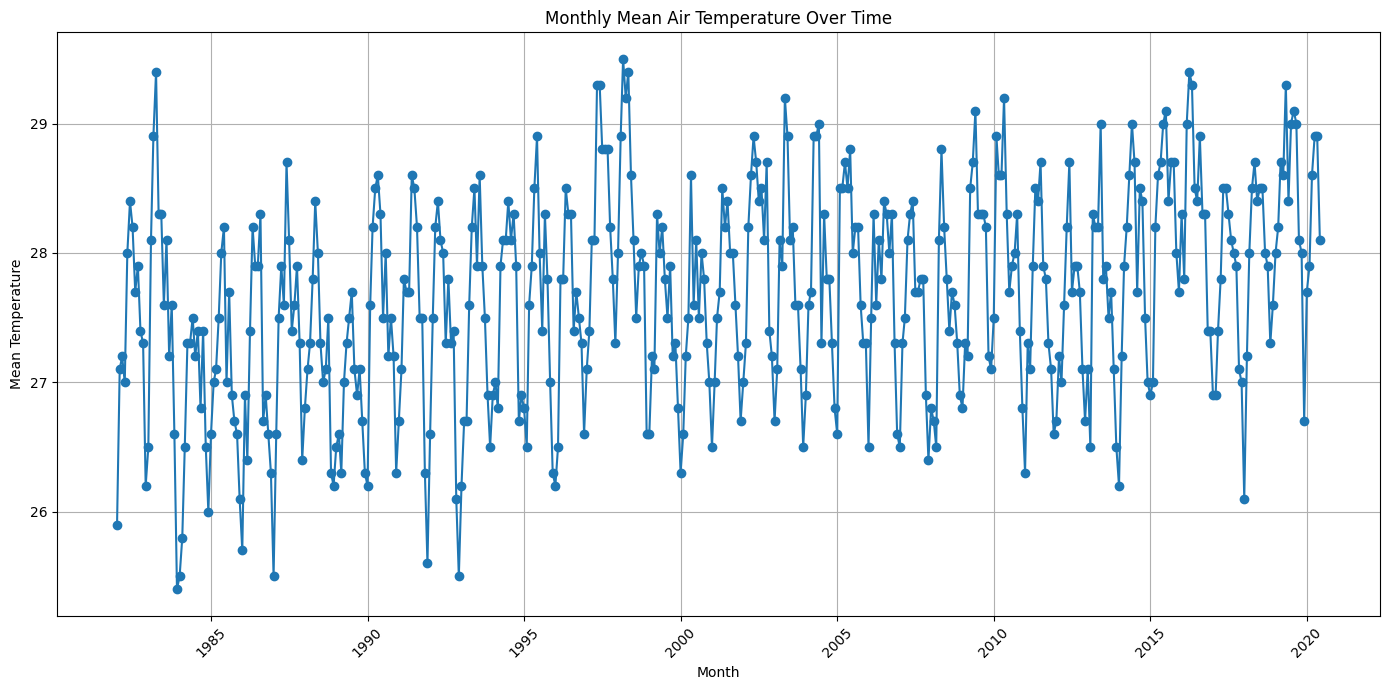

In [13]:
# Visualization of the time series data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['mean_temp'], marker='o', linestyle='-')
plt.title('Monthly Mean Air Temperature Over Time')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

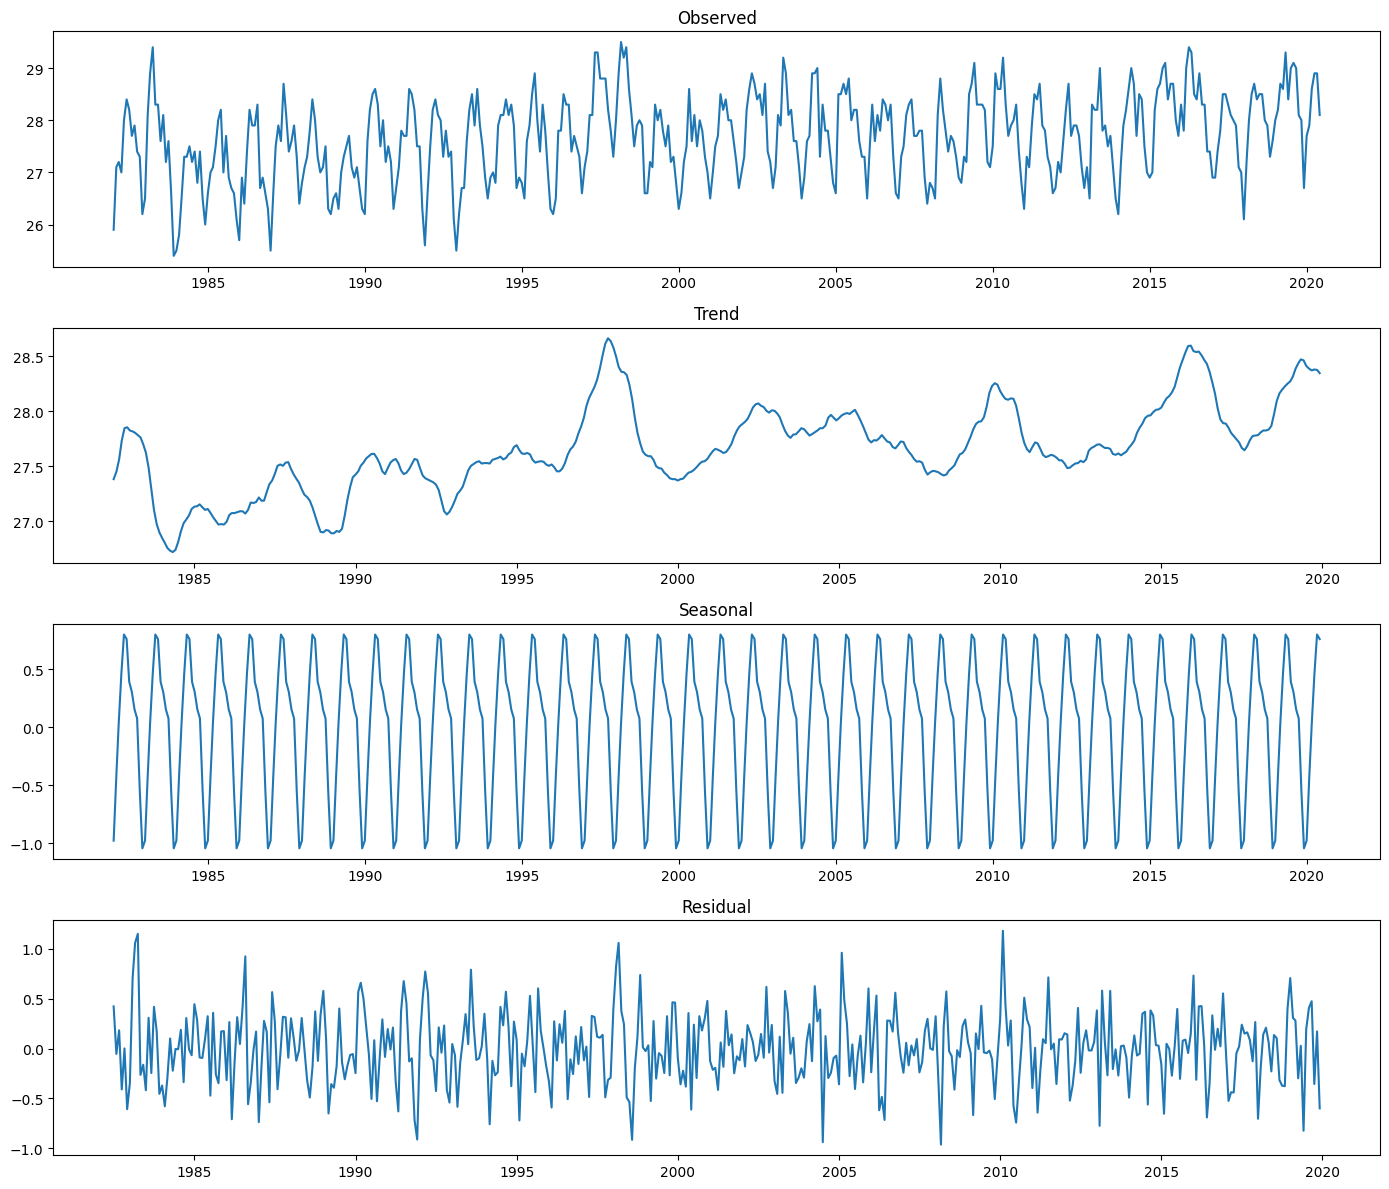

In [15]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['mean_temp'], model='additive', period=12)
plt.figure(figsize=(14, 12))

plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')

plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')

plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

In [16]:

# Checking for stationarity using Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is non-stationary")

check_stationarity(df['mean_temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.265046
p-value                          0.000510
#Lags Used                      18.000000
Number of Observations Used    443.000000
Critical Value (1%)             -3.445198
Critical Value (5%)             -2.868086
Critical Value (10%)            -2.570257
dtype: float64
The series is stationary


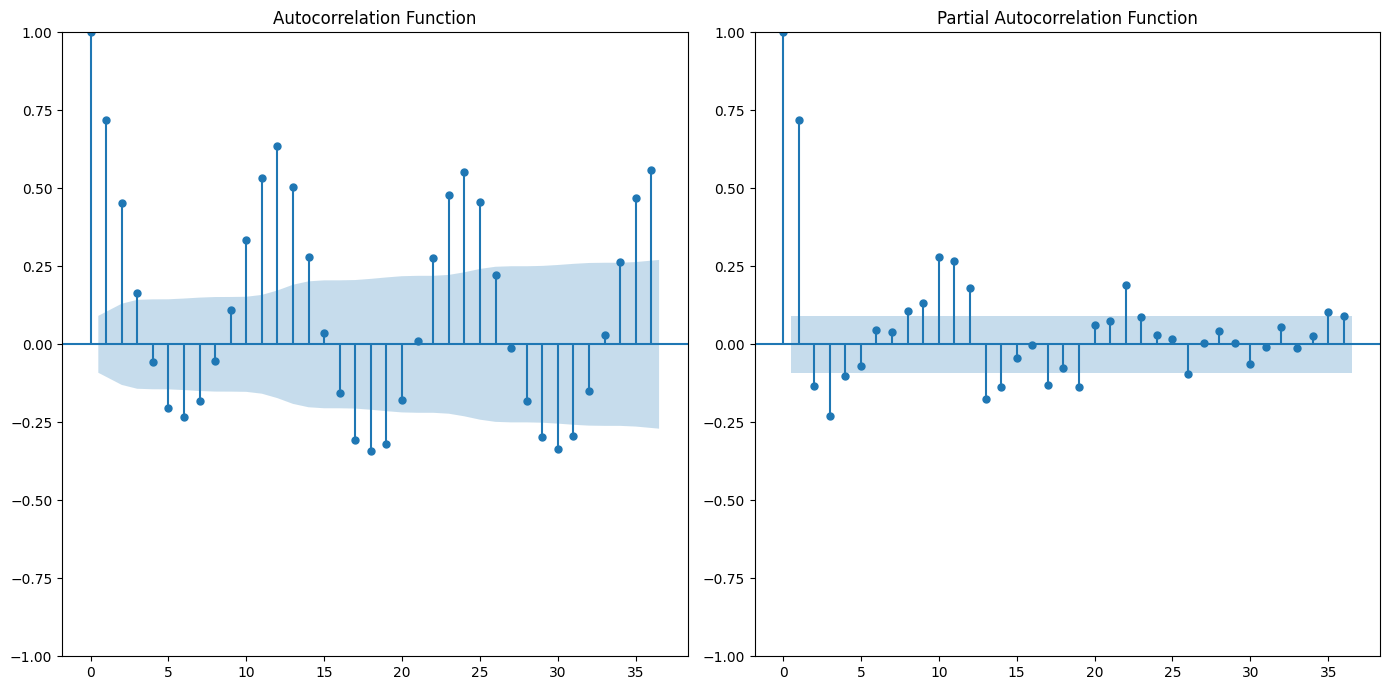

In [19]:
# Plot ACF and PACF
plt.figure(figsize=(14, 7))
plt.subplot(121)
plot_acf(df['mean_temp'], ax=plt.gca(), lags=36)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df['mean_temp'], ax=plt.gca(), lags=36)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [20]:
# Step 4: Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"\nTraining data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")



Training data size: 369
Testing data size: 93



Fitting ARIMA model...
                               SARIMAX Results                                
Dep. Variable:              mean_temp   No. Observations:                  369
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -332.110
Date:                Sun, 18 May 2025   AIC                            670.220
Time:                        08:30:21   BIC                            681.945
Sample:                    01-01-1982   HQIC                           674.878
                         - 09-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9812      0.024    -40.277      0.000      -1.029      -0.933
ma.L1          0.9522      0.038     24.881      0.000       0.877       1.027
sigma2         0.3557      0

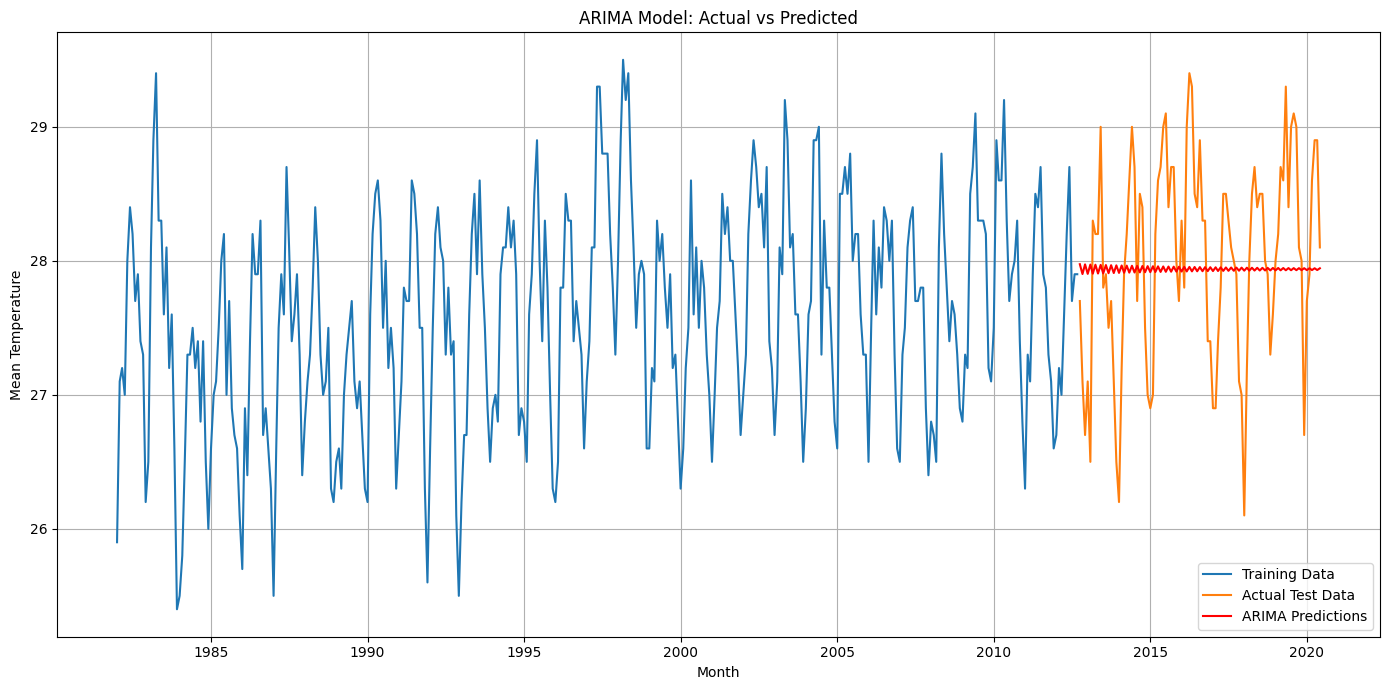

In [22]:
# Step 5: Build and evaluate models

# Model 1: ARIMA
# Function to evaluate model performance
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")

    return {'Model': model_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R²': r2}

# 5.1 ARIMA Model
print("\nFitting ARIMA model...")
# Based on ACF and PACF, determine p, d, q values
# For demonstration, using simple values; you should adjust based on your analysis
p, d, q = 1, 1, 1  # Example values
arima_model = ARIMA(train_data['mean_temp'], order=(p, d, q))
arima_results = arima_model.fit()
print(arima_results.summary())

# Make predictions
arima_predictions = arima_results.forecast(steps=len(test_data))
arima_metrics = evaluate_model(test_data['mean_temp'], arima_predictions, 'ARIMA')

# Plot ARIMA results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['mean_temp'], label='Training Data')
plt.plot(test_data.index, test_data['mean_temp'], label='Actual Test Data')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Fitting SARIMA model...
                                     SARIMAX Results                                      
Dep. Variable:                          mean_temp   No. Observations:                  369
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -213.346
Date:                            Sun, 18 May 2025   AIC                            436.691
Time:                                    08:31:05   BIC                            456.066
Sample:                                01-01-1982   HQIC                           444.398
                                     - 09-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3070      0.073      4.198      0.000       0.164       0.450
ma.L1     

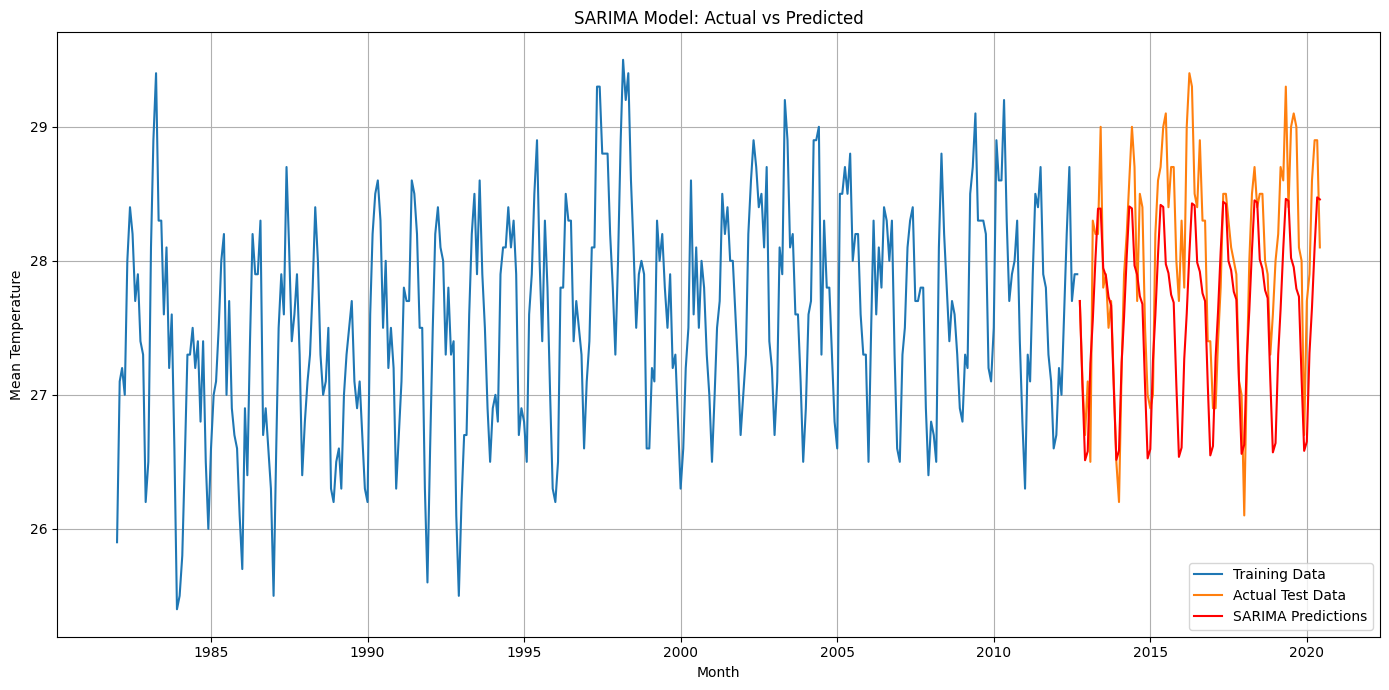

In [23]:
# 5.2 SARIMA Model
print("\nFitting SARIMA model...")
# SARIMA parameters (p, d, q) and seasonal (P, D, Q, s)
# Adjust these based on your analysis of ACF/PACF
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # s=12 for monthly seasonality

sarima_model = SARIMAX(train_data['mean_temp'],
                      order=(p, d, q),
                      seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Make predictions
sarima_predictions = sarima_results.forecast(steps=len(test_data))
sarima_metrics = evaluate_model(test_data['mean_temp'], sarima_predictions, 'SARIMA')

# Plot SARIMA results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['mean_temp'], label='Training Data')
plt.plot(test_data.index, test_data['mean_temp'], label='Actual Test Data')
plt.plot(test_data.index, sarima_predictions, label='SARIMA Predictions', color='red')
plt.title('SARIMA Model: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0ahun82/zfsbc92r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpj0ahun82/e_fxdmcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73251', 'data', 'file=/tmp/tmpj0ahun82/zfsbc92r.json', 'init=/tmp/tmpj0ahun82/e_fxdmcx.json', 'output', 'file=/tmp/tmpj0ahun82/prophet_model6hlggeka/prophet_model-20250518083310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Fitting Prophet model...

Prophet Performance Metrics:
MSE: 0.4379
RMSE: 0.6617
MAE: 0.5193
R²: 0.2238


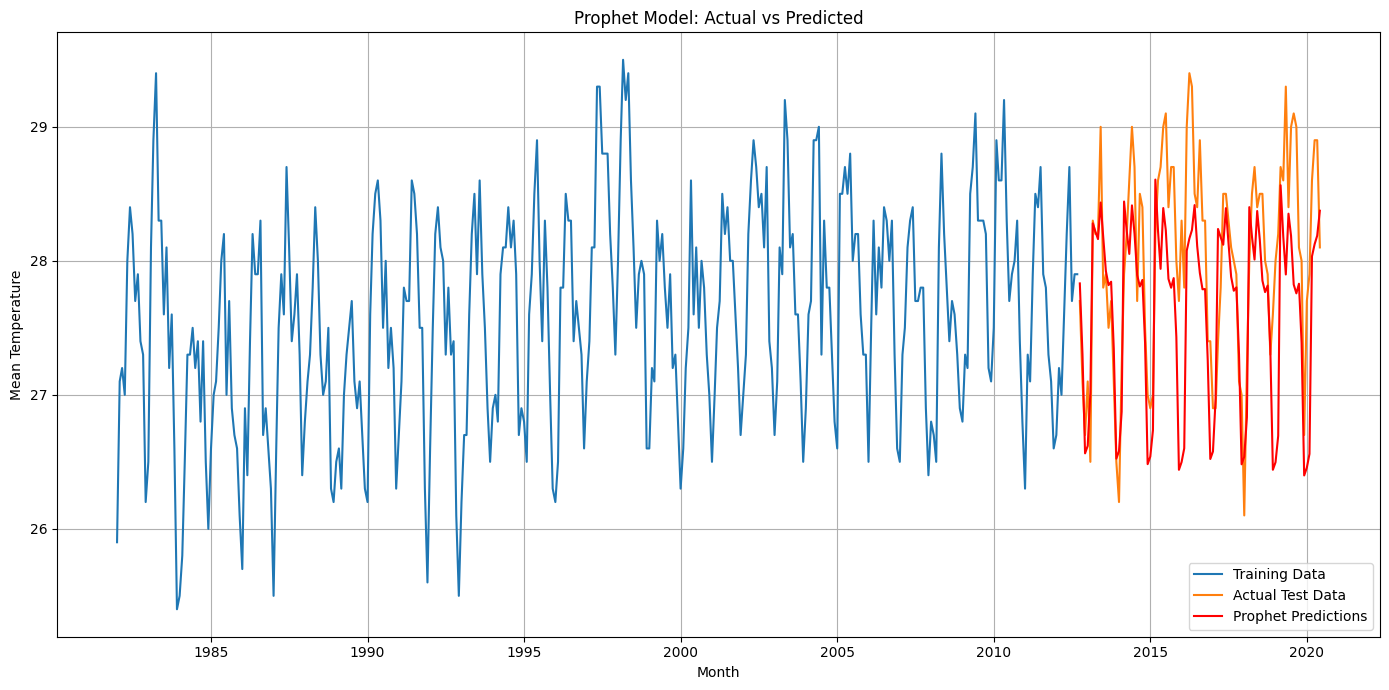

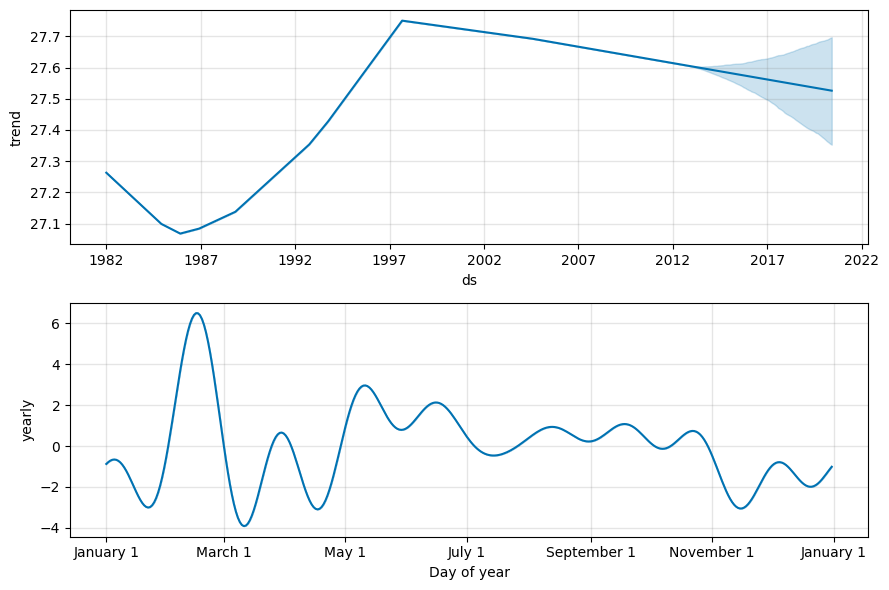

In [25]:
# 5.3 Prophet Model
print("\nFitting Prophet model...")
# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = train_data.reset_index()
prophet_train.rename(columns={'month': 'ds', 'mean_temp': 'y'}, inplace=True)

prophet_test = test_data.reset_index()
prophet_test.rename(columns={'month': 'ds', 'mean_temp': 'y'}, inplace=True)

# Create and fit the model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
prophet_forecast = prophet_model.predict(future)

# Extract predictions for the test period
prophet_predictions = prophet_forecast.tail(len(test_data))['yhat'].values
prophet_metrics = evaluate_model(test_data['mean_temp'], prophet_predictions, 'Prophet')

# Plot Prophet results
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['mean_temp'], label='Training Data')
plt.plot(test_data.index, test_data['mean_temp'], label='Actual Test Data')
plt.plot(test_data.index, prophet_predictions, label='Prophet Predictions', color='red')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Month')
plt.ylabel('Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show Prophet components (trend, yearly seasonality, etc.)
fig = prophet_model.plot_components(prophet_forecast)
plt.show()



In [26]:
# Step 6: Compare model performances
models_comparison = pd.DataFrame([arima_metrics, sarima_metrics, prophet_metrics])
print("\nModels Performance Comparison:")
print(models_comparison)

# Find the best model based on RMSE
best_model_idx = models_comparison['RMSE'].idxmin()
best_model = models_comparison.loc[best_model_idx, 'Model']
print(f"\nThe best performing model is: {best_model} with RMSE: {models_comparison.loc[best_model_idx, 'RMSE']:.4f}")



Models Performance Comparison:
     Model       MSE      RMSE       MAE        R²
0    ARIMA  0.573275  0.757150  0.627105 -0.016237
1   SARIMA  0.406017  0.637194  0.507644  0.280261
2  Prophet  0.437863  0.661712  0.519271  0.223806

The best performing model is: SARIMA with RMSE: 0.6372



Forecasting future months using the best model...

Forecasted mean temperatures for the next 12 months:
            Forecasted_Mean_temp
month                           
2020-07-31             28.314331
2020-08-31             28.357649
2020-09-30             28.240315
2020-10-31             28.136185
2020-11-30             27.539499
2020-12-31             27.005460
2021-01-31             27.116096
2021-02-28             27.664932
2021-03-31             28.134101
2021-04-30             28.541319
2021-05-31             28.873117
2021-06-30             28.794490


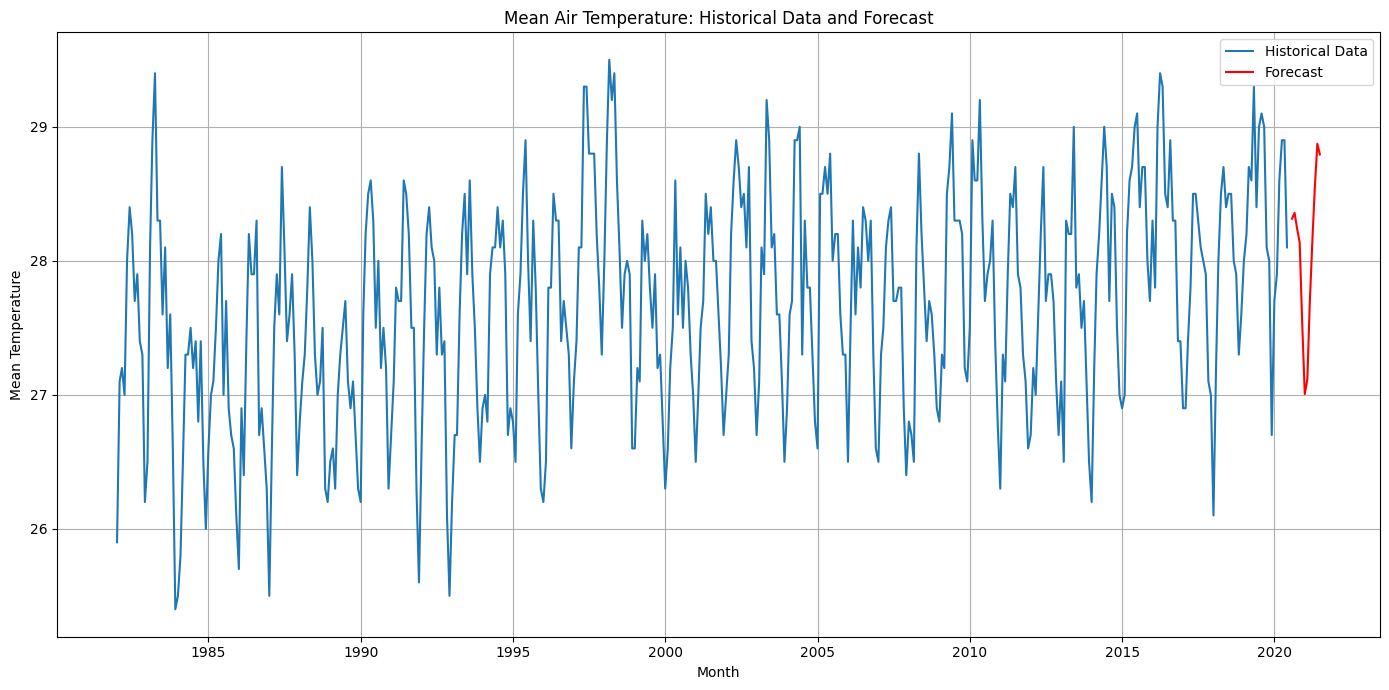

In [28]:
# Step 7: Forecast future months using the best model
# For demonstration, we'll use SARIMA for forecasting (you would use your best model)
print("\nForecasting future months using the best model...")

# Retrain on the full dataset
if best_model == 'SARIMA':
    final_model = SARIMAX(df['mean_temp'],
                          order=(p, d, q),
                          seasonal_order=(P, D, Q, s))
    final_model_fit = final_model.fit(disp=False)

    # Forecast the next 12 months
    forecast_steps = 12
    forecast = final_model_fit.forecast(steps=forecast_steps)

    # Create a date range for the forecast period
    last_date = df.index[-1]
    forecast_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1),
                                   periods=forecast_steps,
                                   freq='M')

    # Create a forecast dataframe
    forecast_df = pd.DataFrame({'month': forecast_dates, 'Forecasted_Mean_temp': forecast})
    forecast_df.set_index('month', inplace=True)

    print("\nForecasted mean temperatures for the next 12 months:")
    print(forecast_df)

    # Plot historical data and forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['mean_temp'], label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecasted_Mean_temp'], label='Forecast', color='red')
    plt.title('Mean Air Temperature: Historical Data and Forecast')
    plt.xlabel('Month')
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif best_model == 'Prophet':
    # Retrain Prophet on full dataset
    prophet_full = df.reset_index()
    prophet_full.rename(columns={'month': 'ds', 'mean_temp': 'y'}, inplace=True)

    final_prophet = Prophet(yearly_seasonality=True)
    final_prophet.fit(prophet_full)

    # Create future dataframe for predictions
    future = final_prophet.make_future_dataframe(periods=12, freq='M')
    prophet_forecast = final_prophet.predict(future)

    # Extract only the forecasted months
    forecast_df = prophet_forecast.tail(12)[['ds', 'yhat']]
    forecast_df.rename(columns={'ds': 'month', 'yhat': 'Forecasted_Mean_temp'}, inplace=True)
    forecast_df.set_index('month', inplace=True)

    print("\nForecasted mean temperatures for the next 12 months:")
    print(forecast_df)

    # Plot historical data and forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['mean_temp'], label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecasted_Mean_temp'], label='Forecast', color='red')
    plt.title('Mean Air Temperature: Historical Data and Forecast')
    plt.xlabel('Month')
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif best_model == 'ARIMA':
    final_model = ARIMA(df['mean_temp'], order=(p, d, q))
    final_model_fit = final_model.fit()

    # Forecast the next 12 months
    forecast = final_model_fit.forecast(steps=12)

    # Create a date range for the forecast period
    last_date = df.index[-1]
    forecast_dates = pd.date_range(start=pd.Timestamp(last_date) + pd.DateOffset(months=1),
                                   periods=12,
                                   freq='M')

    # Create a forecast dataframe
    forecast_df = pd.DataFrame({'month': forecast_dates, 'Forecasted_Mean_temp': forecast})
    forecast_df.set_index('month', inplace=True)

    print("\nForecasted mean temperatures for the next 12 months:")
    print(forecast_df)

    # Plot historical data and forecast
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['mean_temp'], label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecasted_Mean_temp'], label='Forecast', color='red')
    plt.title('Mean Air Temperature: Historical Data and Forecast')
    plt.xlabel('Month')
    plt.ylabel('Mean Temperature')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [29]:
# Step 8: Save the model and results
import pickle
with open('best_air_temp_model.pkl', 'wb') as f:
    pickle.dump(final_model_fit, f)
print("Model saved successfully!")

Model saved successfully!


In [30]:
from google.colab import files
files.download('best_air_temp_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
import pickle
# Load the model
with open('best_air_temp_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use the loaded model to make predictions
new_forecast = loaded_model.forecast(steps=12)  # Forecast next 12 months

In [32]:
print("Forecast for next 12 months:")
print(new_forecast)


Forecast for next 12 months:
2020-07-01    28.314331
2020-08-01    28.357649
2020-09-01    28.240315
2020-10-01    28.136185
2020-11-01    27.539499
2020-12-01    27.005460
2021-01-01    27.116096
2021-02-01    27.664932
2021-03-01    28.134101
2021-04-01    28.541319
2021-05-01    28.873117
2021-06-01    28.794490
Freq: MS, Name: predicted_mean, dtype: float64


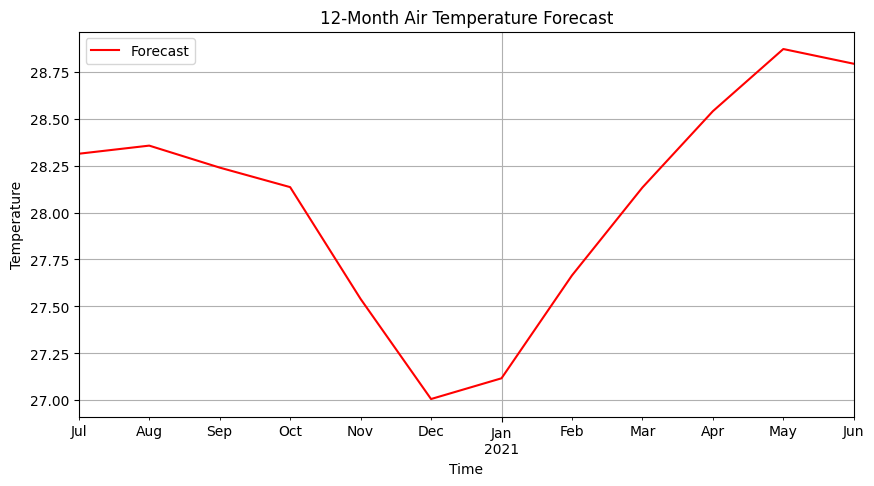

In [33]:
import matplotlib.pyplot as plt

# Plot forecast
plt.figure(figsize=(10, 5))
new_forecast.plot(label='Forecast', color='red')

# Optional: If you have the original data
# df['value_column'].plot(label='Historical Data', color='blue')  # Replace with your actual column name

plt.title("12-Month Air Temperature Forecast")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.show()
